In [1]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from keras.models import Model, load_model, model_from_json
from keras.optimizers import Adam, SGD
from keras import backend as K
import cv2
import os
from skimage.io import imread, imshow, imsave
import numpy as np
import matplotlib.pyplot as plt

## User inputs

In [6]:
level = 'l4l5inf'
img_path = 'images/'
pred_path = 'masks/'
w = 128
h = 128
channels = 1

## Create masks

In [3]:
model_name = 'cep_unet10'

# Optimal threshold by level
opt_th = {'l4l5inf': 0.32, 'l4l5sup': 0.24,
         'l5s1inf': 0.3, 'l5s1sup': 0.24}

# Load model
fn1 = 'models/' + model_name + '_' + level + '.json'
fn2 = 'models/' + model_name + '_' + level + '.h5'
json_file = open(fn1,'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(fn2)

model.compile(optimizer=Adam( lr = 1e-4 ), loss = 'binary_crossentropy')
print('='*40)
print('Loaded: ' + model_name)

if os.path.exists(pred_path):
    print('Prediction path: exists')
else:
    print('Prediction path: created')
    os.mkdir(pred_path)
    
img_names = next(os.walk(img_path))[2]

for n, id_ in enumerate(img_names):
    fn = img_path + id_
    if ( id_ == '.DS_Store'):
        continue
    mri = imread(fn)
    mri = cv2.resize(mri, dsize=(w, h), interpolation=cv2.INTER_LINEAR) # resize to 128 x 128
    mri = cv2.normalize(mri, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F) # normalize 0-1
    mri = mri[np.newaxis,:,:,np.newaxis]
    # Make predictions
    pred = model.predict(mri)
    pred = np.squeeze(pred)
    th = opt_th[level] # use the optimal thresholds
    pred = (pred > th).astype(np.uint8) * 255
    imsave(pred_path + '/' +level + '_' + id_, pred, check_contrast=False)

print('Predicting on ' + str(len(img_names)) + ' images.')
print('Predictions saved')
print('='*40)

/Users/linshanshanwang/opt/anaconda3/envs/CEPseg/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Loaded: cep_unet10
Prediction path: exists
Predicting on 1 images.
Predictions saved


## Visualize Predictions

In [4]:
def plot_sample(img_name, pred_name):
    
    img = imread(img_path + img_name)
    pred = imread(pred_path + pred_name)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10), dpi=300)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('UTE Scan')

    ax[1].imshow(img, cmap='gray')
    ax[1].contour(pred.squeeze(), colors='blue', levels=[0.5])
    ax[1].set_title('UTE Scan with contour')

    ax[2].imshow(pred.squeeze(), vmin=0, vmax=1, cmap='gray')
    ax[2].set_title('Predicted CEP')

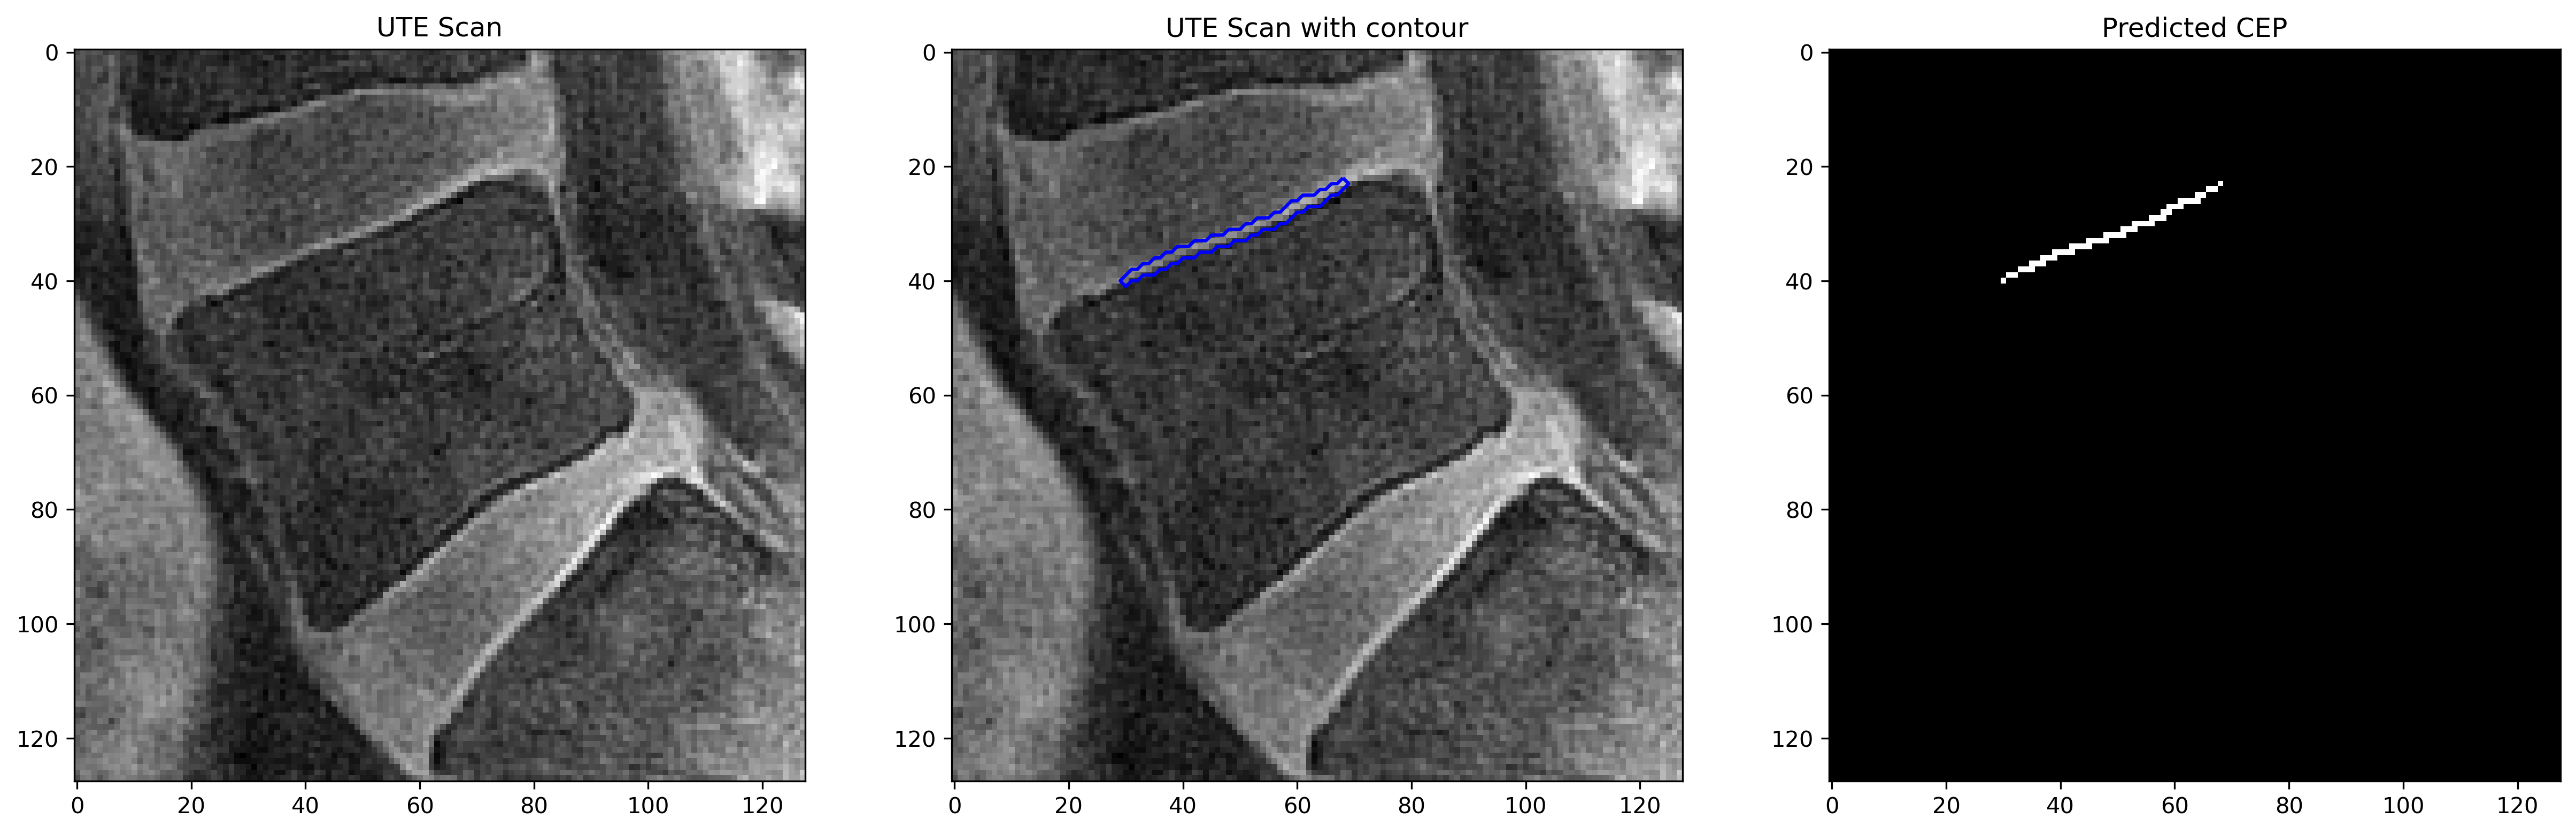

In [5]:
plot_sample("example.tif", "l4l5inf_example.tif")